# 1. Data preprocessing

In [1]:
# %pip install matplotlib scikit-learn pandas

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import re

In [26]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)

df1['domain'], df2['domain'] = 1, 2

# Data oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Split d1
df1_train, df1_dev = train_test_split(df1, stratify=df1['label'], random_state=0, test_size=1000)
# Split d2
df_2_0 = df2[df2['label'] == 0].sample(n=500, random_state=0)
df_2_1 = df2[df2['label'] == 1].sample(n=500, random_state=0)
df2_train = df2[[i not in pd.concat([df_2_0, df_2_1]).index for i in df2.index]].reset_index(drop=True)
df2_dev = pd.concat([df_2_0, df_2_1]).reset_index(drop=True)

# Join data in both domains for trating them jointly (Augmentation)
df_train = pd.concat([df1_train, df2_train, df2_dev]).reset_index(drop=True)
# df_train, _ = RandomUnderSampler().fit_resample(df_train, df_train['label'])
df_dev = pd.concat([df1_dev]).reset_index(drop=True)

# Shuffle datasets
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_dev = df_dev.sample(frac=1).reset_index(drop=True)

In [25]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)
# Get domains
df1['domain'],df2['domain'] = 0, 1

# Train dev split
df1_train, df1_dev = train_test_split(df1, stratify=df1['label'], random_state=42)
df2_train, df2_dev = train_test_split(df2, stratify=df2['label'], random_state=42)

# Join data in both domains for trating them jointly (Augmentation)
df_train = pd.concat([df1_train, df2_train]).reset_index(drop=True)
df_dev = pd.concat([df1_dev, df2_dev]).reset_index(drop=True)

# Shuffle datasets
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_dev = df_dev.sample(frac=1).reset_index(drop=True)

# 3 DL Models (BiLSTM)

In [27]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [28]:
# # Weights function
# def weights(df):
#     w = list(len(df['label'])/df['label'].value_counts())
#     sample_weights = [0] * df.shape[0]
#     for idx, label in enumerate(df['label']):
#         sample_weights[idx] = w[label]
#     return sample_weights

# Prepare pytorch dataset
class Dataset(Dataset):
    def __init__(self, text, labels):
        self.text = text
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        text = torch.tensor(self.text[idx])
        label = torch.tensor(self.labels[idx])
        return text, label
    
# Define collate (pre_process) function
def collate_batch(batch):  
    texts, labels = zip(*batch)
    text_len = [len(txt) for txt in texts]
    text = nn.utils.rnn.pad_sequence(texts, batch_first=True).to(device)
    labels = torch.tensor(labels, dtype=torch.float32).to(device).reshape(-1,1)
    return text, labels, text_len

# Create datasets
train_DS = Dataset(df_train['text'], df_train['label'])
dev_DS = Dataset(df_dev['text'], df_dev['label'])

# # Sample train data
# sampler_tr = torch.utils.data.WeightedRandomSampler(weights(df_train), num_samples=len(train_DS), replacement=True)
# sampler_ts = torch.utils.data.WeightedRandomSampler(weights(df_dev), num_samples=len(dev_DS), replacement=True)

# Create dataloaders
bs = 32
x_tr_dl = DataLoader(train_DS, batch_size=bs, collate_fn=collate_batch)
x_dev_dl = DataLoader(dev_DS, batch_size=bs, collate_fn=collate_batch)

# x_tr_dl = DataLoader(train_DS, batch_size=bs, collate_fn=collate_batch, sampler=sampler_tr)
# x_dev_dl = DataLoader(dev_DS, batch_size=bs, collate_fn=collate_batch, sampler=sampler_ts)

In [29]:
# Bidirectional LSTM model
class BiLSTM(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers):
        super(BiLSTM, self).__init__()
        # Embeding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # BiLSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=n_layers, batch_first=True,dropout = 0.5)
        # Linear layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        # Sigmoid layer
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        # Embeding 
        embedded = self.dropout(self.embedding(text))
        # Batch packing
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False)
        # BiLSTM pass
        output, (hidden, cell_state) = self.lstm(packed_embedded)
        # Concatenate hidden states in the BiLSTM
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        # Linear layer
        linear = self.fc(hidden)
        # Return the classifier's output
        return self.Sigmoid(linear)

In [30]:
# Instantiate the model
model = BiLSTM(vocab_size=90000, embedding_dim=128, hidden_dim=256*2, output_dim=1, n_layers=2).to(device)
print(model)

BiLSTM(
  (embedding): Embedding(90000, 128, padding_idx=0)
  (lstm): LSTM(128, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (Sigmoid): Sigmoid()
)


In [31]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters())

# Loss fn
# loss_fn = nn.BCEWithLogitsLoss()
# Weights function
def weights_class(y):
    y = pd.Series(y.int().numpy(force=True).reshape(-1))
    w = len(y)/y.value_counts()
    try:
        return w[1]
        
    except:
        return 0

In [32]:
from tqdm import tqdm
from sklearn.metrics import f1_score
# Train
def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss, total, acc, real, preds = 0, 0, 0, [], []
    for X, y, text_len in tqdm(dataloader):
        pred = model(X, text_len)               # Forward pass
        loss_fn = nn.BCELoss(weight = torch.tensor(weights_class(y)).to(device))
        loss = loss_fn(pred, y)                 # Compute loss 
        loss.backward()                         # Backpropagation
        optimizer.step()                        # Update parameters
        optimizer.zero_grad()                   # Reset gradient
    
        # Metrics
        acc += torch.sum((pred>=0.5).float() == y)
        real.extend((y>=0.5).int().detach().cpu().numpy().reshape(-1,1))
        preds.extend((pred>=0.5).int().detach().cpu().numpy().reshape(-1,1))
        train_loss += loss.item()
        total += len(y)
    # General metrics
    train_loss /= total
    return train_loss, acc/size, f1_score(real, preds)

In [33]:
# Test
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, total, acc, real, preds = 0, 0, 0, [], []
    with torch.no_grad():       # Specify no gradient
        for X, y, text_len in tqdm(dataloader):
            pred = model(X, text_len)               # Forward pass   
            loss_fn = nn.BCELoss(weight = torch.tensor(weights_class(y)).to(device))
            
            # Metrics
            acc += torch.sum((pred>=0.5).float() == y)
            real.extend((y>=0.5).int().detach().cpu().numpy().reshape(-1,1))
            preds.extend((pred>=0.5).int().detach().cpu().numpy().reshape(-1,1))
            
            test_loss += loss_fn(pred, y).item()    # Compute loss  
            total += len(y)                         # Total observations

    # General metrics
    test_loss /= total
    return test_loss, acc/size, f1_score(real, preds)

In [34]:
from tqdm import tqdm, tqdm_notebook # show progress bar

# Epochs
epochs = 25
train_loss, valid_loss = [], []
print("Training BiLSTM network model!")
for t in range(epochs):
    tl, train_acc, f1_tr = train(x_tr_dl, model, optimizer)
    vl, valid_acc, f1_ts = test(x_dev_dl, model)
    # Losses to dict
    train_loss.append(tl)
    valid_loss.append(vl)

    # Print results
    tqdm.write(
        f'epoch #{t}\ttrain_acc: {train_acc:.3f}\tvalid_acc: {valid_acc:.3f}',
    )
    tqdm.write(
        f'epoch #{t}\tf1_tr: {f1_tr:.3f}\tf1_ts: {f1_ts:.3f}',
    )

Training BiLSTM network model!


100%|██████████| 32/32 [00:01<00:00, 19.09it/s]


epoch #0	train_acc: 0.800	valid_acc: 0.615
epoch #0	f1_tr: 0.234	f1_ts: 0.685


100%|██████████| 32/32 [00:01<00:00, 19.06it/s]


epoch #1	train_acc: 0.809	valid_acc: 0.609
epoch #1	f1_tr: 0.351	f1_ts: 0.651


100%|██████████| 32/32 [00:01<00:00, 19.05it/s]


epoch #2	train_acc: 0.815	valid_acc: 0.622
epoch #2	f1_tr: 0.421	f1_ts: 0.695


100%|██████████| 32/32 [00:01<00:00, 19.06it/s]


epoch #3	train_acc: 0.834	valid_acc: 0.629
epoch #3	f1_tr: 0.509	f1_ts: 0.675


100%|██████████| 32/32 [00:01<00:00, 19.01it/s]


epoch #4	train_acc: 0.848	valid_acc: 0.654
epoch #4	f1_tr: 0.561	f1_ts: 0.657


100%|██████████| 32/32 [00:01<00:00, 19.07it/s]


epoch #5	train_acc: 0.871	valid_acc: 0.699
epoch #5	f1_tr: 0.647	f1_ts: 0.692


100%|██████████| 32/32 [00:01<00:00, 19.08it/s]


epoch #6	train_acc: 0.893	valid_acc: 0.723
epoch #6	f1_tr: 0.719	f1_ts: 0.727


100%|██████████| 32/32 [00:01<00:00, 19.03it/s]


epoch #7	train_acc: 0.914	valid_acc: 0.741
epoch #7	f1_tr: 0.777	f1_ts: 0.734


 57%|█████▋    | 302/532 [00:41<00:31,  7.21it/s]


KeyboardInterrupt: 

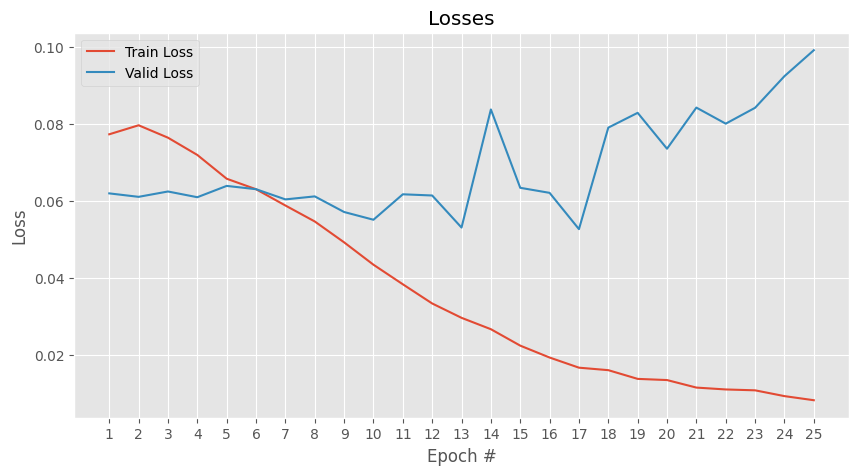

In [20]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
epoch_ticks = range(1, t+1 + 1)
plt.plot(epoch_ticks, train_loss)
plt.plot(epoch_ticks, valid_loss)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [21]:
def predict(dl, ln):
    with torch.no_grad():  # Disable gradient computation for efficiency
        preds, acc, test_acc = [], 0, 0
        for X, y, text_len in dl:
            # Dev data
            pred = model(X, text_len)
            test_acc += torch.sum((pred>=0.5).float() == y)
    return (test_acc/ln).detach().cpu().numpy().item()

In [22]:
predict(x_tr_dl, df_train.shape[0])

0.9960625767707825

In [23]:
predict(x_dev_dl, df_dev.shape[0])

0.706000030040741

# Predict on sample data

In [17]:
test = pd.read_json('../Data/test_data.json', lines=True)['text']
# train = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in df_train['text']]
test = [[t if t != 0 else 1 for t in ls] for ls in test]

In [18]:
preds = []
for line in test:
    text_tensor = torch.tensor(line).unsqueeze(0).to(device)
    text_length = torch.tensor([len(line)])
    # Pass the sequence and its length to the model
    prediction = model(text_tensor, text_length)
    preds.extend((prediction>=0.5).int().detach().cpu().numpy().reshape(-1))

In [19]:
test_df = pd.DataFrame(columns = ['id', 'value'])
for idx, v in enumerate(preds):
    test_df.loc[idx] = [idx, preds[idx]]
test_df.to_csv('predictions.csv', index=False)

In [20]:
test_df['value'].value_counts()

value
1    2290
0    1710
Name: count, dtype: int64

In [ ]:
#  Export model
model_scripted = torch.jit.script(model.to('cpu') # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

In [ ]:
# Load Model
model = torch.jit.load('model_scripted.pt')
model.eval()